# Progressive Regression + Lagged Features

In [107]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [108]:
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import (ElasticNet, Lasso, Ridge, LinearRegression)
from sklearn.model_selection import (cross_validate, TimeSeriesSplit)

In [109]:
%load_ext watermark
%watermark -v -p pandas,numpy,seaborn,matplotlib,sklearn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.7.4
IPython 7.14.0

pandas 1.0.3
numpy 1.18.4
seaborn 0.9.0
matplotlib 3.1.3
sklearn 0.0


In [110]:
mpl.rcParams['figure.dpi']= 150
sns.set()

## Temp class to use for progressive regression

In [300]:
import src

ModuleNotFoundError: No module named 'src'

In [111]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class ProgressiveRegression(BaseEstimator, RegressorMixin):
    """Wraps an estimator to faciliate problems with time correlation in 
    the targets.  This is done by having
    - fit(X,y) append y with a lag of 1 to x. 
    - predict(X) append to each sample the prediction on the previous sample.
   
    Parameters
    ----------
    base_estimator : estimator, default=LinearRegression()
        The base scikit-learn compatible estimator used for prediction.

    Attributes
    ----------
    base_estimator_ : estimator
        The base estimator used for prediction.
    """

    def __init__(self, 
        base_estimator = LinearRegression(), 
        target_scaler = StandardScaler()
    ):
        self.base_estimator = base_estimator
        self.target_scaler = target_scaler
    
    @staticmethod
    def _shift(arr, num, fill_value = np.nan):
        """ Shifts a numpy 1D array without looping around
        
        Parameters
        ----------
        arr : {ndrarray} of shape (n, 1)
        num : shift amount
        fill_value: {np.float} value to insert into the beginning
        of the array after shifting

        Returns
        -------
        {ndarray} of shape (n,1) with values shifter by num
        """
        result = np.empty_like(arr)
        if num > 0:
            result[:num] = fill_value
            result[num:] = arr[:-num]
        elif num < 0:
            result[num:] = fill_value
            result[:num] = arr[-num:]
        else:
            result[:] = arr
        return result
    
    def fit(self, X, y):
        """Fit progressive regression model.

        Parameters
        ----------
        X : {ndarray} of shape (n_samples, n_features)
            Training data
        y : ndarray of shape (n_samples,)
            Target values

        Returns
        -------
        self : return an instance of self.
        """
        X, y = check_X_y(X, y, ensure_min_features = 0)

        y_lag1 = self._shift(y, 1).reshape(-1, 1)
        y_lag1[0] = y[0]
        y_lag1 = self.target_scaler.fit_transform(y_lag1)
        self.last_target = self.target_scaler.transform(y[-1].reshape(-1,1))
        X_new = np.column_stack((X, y_lag1))
        self.base_estimator.fit(X_new, y)

        self.is_fitted_ = True
        return self
    
    def predict(self, X):
        """Predict regression value for X.

        The predicted regression value for each point is computed using
        the predicted value for the previous point as a feature

        Parameters
        ----------
        X : {array-like} of shape (n_samples, n_features)
            The training input samples. 

        Returns
        -------
        y : ndarray of shape (n_samples,)
            The predicted regression values.
        """
        check_is_fitted(self)        
        X = check_array(X, ensure_min_features = 0)
        X_new = np.column_stack((X, np.zeros((len(X), 1))))
        X_new[0,-1] = self.last_target
        y_pred = np.zeros((len(X),1))
        
        for i in range(len(X)-1):
            # need to reshape individual passed to estimator so that they 
            # are 2D arrays 
            y_pred[i] = self.base_estimator.predict(X_new[i,:].reshape(1, -1))
            X_new[i+1,-1] = self.target_scaler.transform(y_pred[i].reshape(-1,1))
        y_pred[-1] = self.base_estimator.predict(X_new[-1,:].reshape(1,-1)) 
        
        return y_pred


## Reading the data

In [112]:
RAW_PATH = '../data/raw'
PROCESSED_PATH = '../data/processed'

Read in processed features previously built

In [113]:
train_features = pd.read_csv(
    os.path.join(PROCESSED_PATH, 'lag7_features_train.csv')
)
train_labels = pd.read_csv(
    os.path.join(RAW_PATH, 'dengue_labels_train.csv')
)
test_features = pd.read_csv(
    os.path.join(PROCESSED_PATH, 'lag7_features_test.csv')
)

Seperate features and targets by city, We need to convert the targets to floats
for compatibility with `progestimator`

In [116]:
train_features_sj = train_features[
    train_features['city'] == 'sj'
].drop('city', axis = 1)
train_features_iq = train_features[
    train_features['city'] == 'iq'
].drop('city', axis = 1)

y_train_sj = train_labels[
    train_labels['city'] == 'sj'
]['total_cases'].astype('float')
y_train_iq = train_labels[
    train_labels['city'] == 'iq'
]['total_cases'].astype('float')

test_features_sj = test_features[
    test_features['city'] == 'sj'
].drop('city', axis = 1)
test_features_iq = test_features[
    test_features['city'] == 'iq'
].drop('city', axis = 1)

## Model

We want the ratio of data in each city to the full dataset to compute 
combined average CV scores

In [117]:
sj_ratio = len(train_features_sj) / len(train_features)
iq_ratio = len(train_features_iq) / len(train_features)

We need different pipelines for our date-related features and the other numerical
features

In [260]:
categorical_features = ['monthofyear']
numerical_features = list(train_features_sj.columns.values)
numerical_features.remove('monthofyear')
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder())
])
numerical_transformer = Pipeline([
    ('scale', StandardScaler()),
#    ('poly', PolynomialFeatures(2))
])
preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)
])

### San Juan

In [261]:
plasso_1 = ProgressiveRegression(Lasso(1.45))
model_sj = Pipeline([
    ('pre', preprocessor),
    ('lasso', plasso_1)
])

In [262]:
cv_res_sj = cross_validate(
    estimator = model_sj,
    X = train_features_sj,
    y = y_train_sj,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
sj_score = np.mean(cv_res_sj['test_score'])
sj_score

-28.363723909873364

Lasso $\alpha \approx 1.45$ seems to be a good parameter, with better CV scores than
our results using fbprophet.

#### Visualization

In [291]:
model_sj.fit(train_features_sj, y_train_sj)
y_val_sj = model_sj.predict(train_features_sj).flatten()

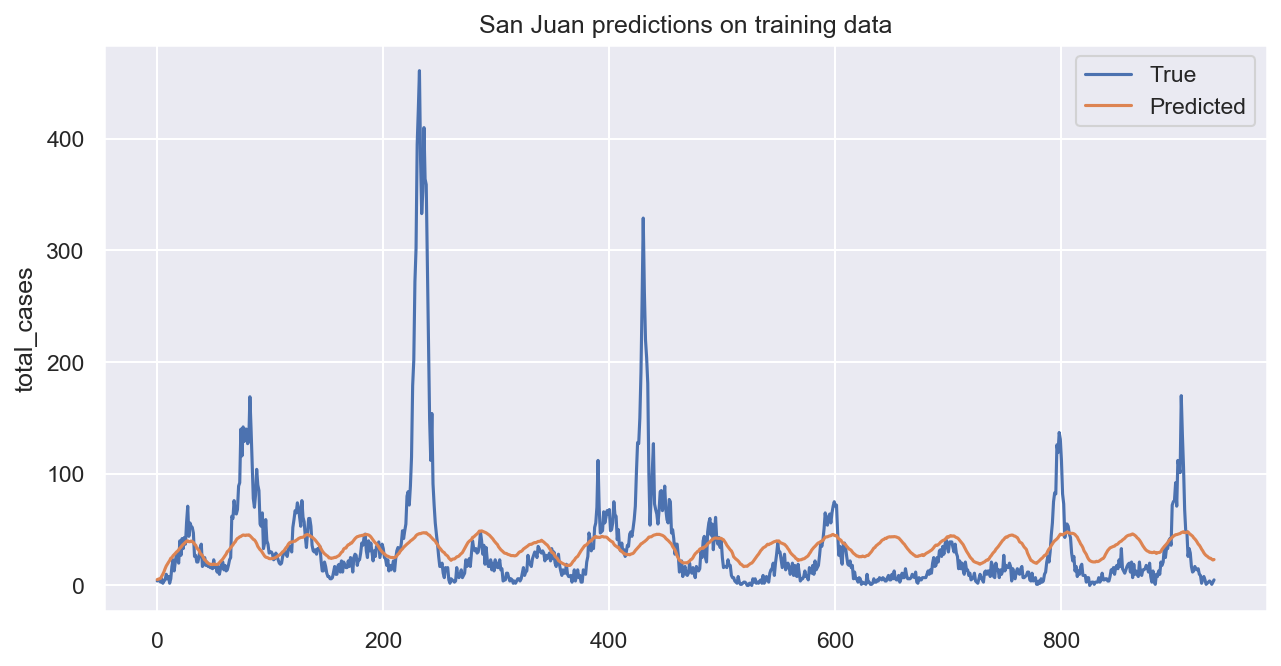

In [244]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = y_train_sj, x = train_features_sj.index.values, ax = ax)
sns.lineplot(y = y_val_sj, x = train_features_sj.index.values, ax = ax)
ax.set(title = 'San Juan predictions on training data')
ax.legend(['True', 'Predicted'])

### Iquitos

In [282]:
plasso_2 = ProgressiveRegression(Lasso(0.3))
model_iq = Pipeline([
    ('pre', preprocessor),
    ('lasso', plasso_2)
])

In [283]:
cv_res_iq = cross_validate(
    estimator = model_iq,
    X = train_features_iq,
    y = y_train_iq,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
iq_score = np.mean(cv_res_iq['test_score'])
iq_score

-6.67026939768583

#### Visualization

In [290]:
model_iq.fit(train_features_iq, y_train_iq)
y_val_iq = model_iq.predict(train_features_iq).flatten()

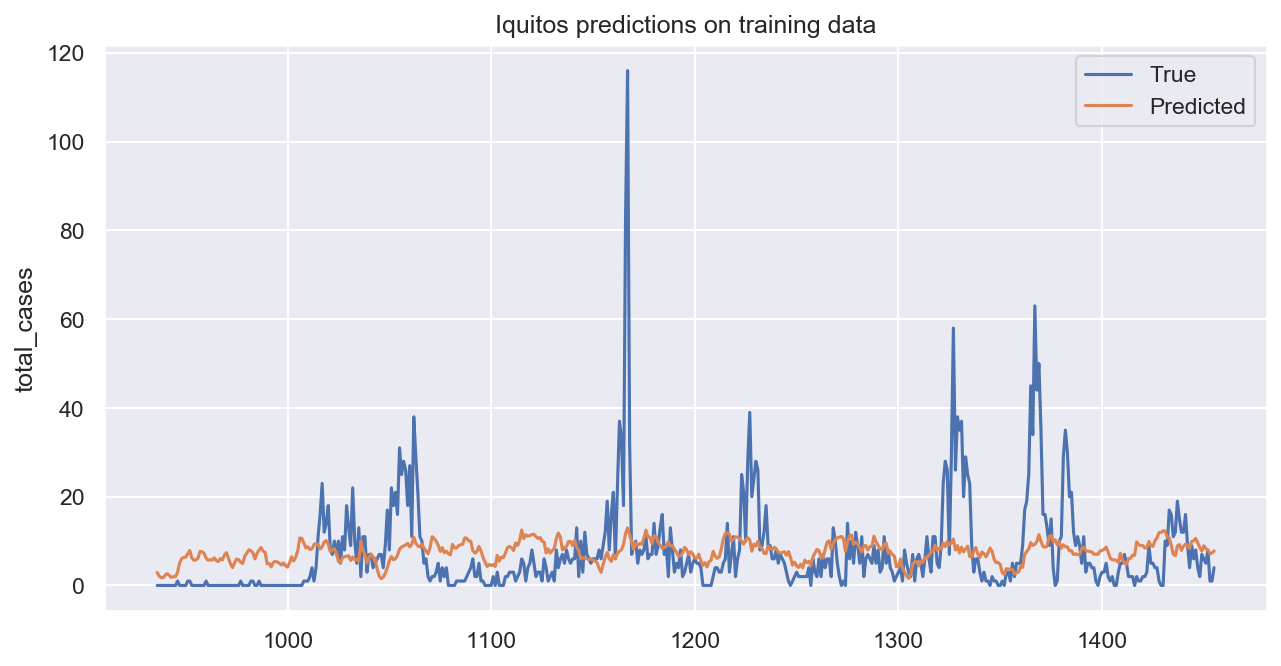

In [285]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = y_train_iq, x = train_features_iq.index.values, ax = ax)
sns.lineplot(y = y_val_iq, x = train_features_iq.index.values, ax = ax)
ax.set(title = 'Iquitos predictions on training data')
ax.legend(['True', 'Predicted'])

### Overall CV result

In [286]:
sj_ratio * sj_score + iq_ratio * iq_score

-20.616061584092105

This is much better than any of the previous CV scores, which warrants a submission

## Model predictions

In [288]:
lagf_sub = pd.read_csv(
    os.path.join(RAW_PATH, 'submission_format.csv'))

In [292]:
y_pred_sj = model_sj.predict(test_features_sj)
y_pred_iq = model_iq.predict(test_features_iq)

In [296]:
y_pred = np.concatenate((y_pred_sj, y_pred_iq))
lagf_sub['total_cases'] = np.round(y_pred).astype(int)
lagf_sub.to_csv('../models/prog_and_lag.csv', index = None)

#### Model plots

San Juan

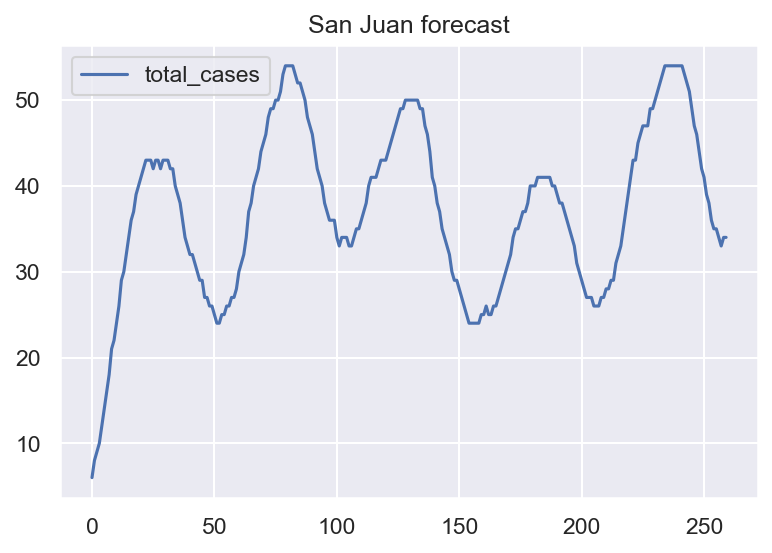

In [297]:
lagf_sub[lagf_sub['city'] == 'sj'].plot(
    y = 'total_cases', 
    title = 'San Juan forecast'
)

Iquitos

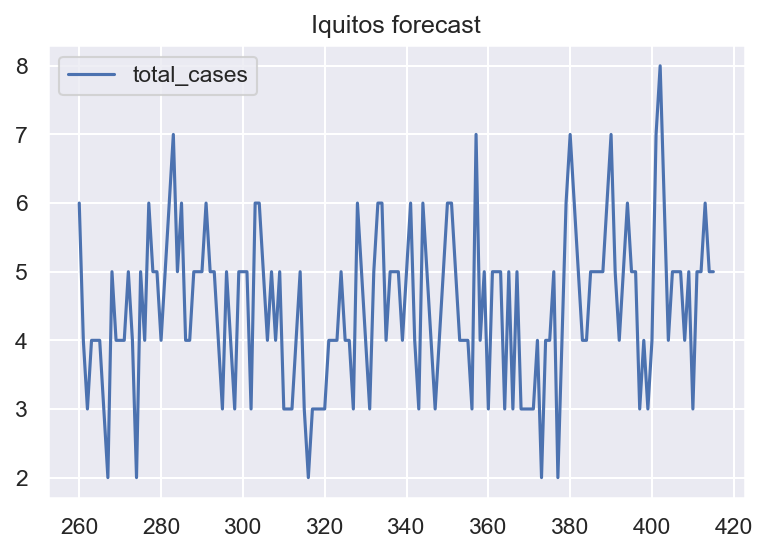

In [298]:
lagf_sub[lagf_sub['city'] == 'iq'].plot(
    y = 'total_cases',
    title = 'Iquitos forecast',
)

#### Leaderboard results